# Univariate Gold Price Analysis Using K-Means and DBSCAN

## 1.0 Business understanding

### 1.1 Business objective

### 1.2 Situational assessment

**Research Question #1:**

Are there distinct clusters of gold prices?

**Hypothesis Couplet**

Null Hypothesis (H<sub>0</sub>): •	There are no differentiated clusters of gold prices.


Alternate Hypothesis (H<sub>1</sub>): There are differentiated clusters of gold prices.


## 2.0 Data Understanding

### 2.1 Prelimary data analysis

#### 2.1.1 Data mining goals

#### 2.1.2 Import libraries

In [126]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import numpy as np
import seaborn as sns
import itertools
import warnings

In [127]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score as ss
from sklearn.decomposition import PCA
from IPython.display import clear_output

#### 2.1.3 Suppress warnings

In [128]:
warnings.filterwarnings('ignore')

#### 2.1.4 Data ingestion

In [129]:
# Import dataset
#create 2-dimensional dataFrames from a imported data.
#Choose the local file (baseball.csv).
#NOTE: YOU WILL NEED TO ALLOW THIRD-PARTY COOKIES FROM THIS SITE colab.research.google.com
from google.colab import files
uploaded = files.upload()

Saving gold_price_data.csv to gold_price_data (2).csv


In [130]:
file_name = "gold_price_data.csv"

In [131]:
# Load dataset
df=pd.read_csv(file_name)
df.head(5)

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


#### 2.1.5 Data description

**High Level Data Dictionary**

* Date: Date
* Value: Gold price per ounce

### 2.4 Data quality

#### 2.4.1 Check for missing values

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10787 non-null  object 
 1   Value   10787 non-null  float64
dtypes: float64(1), object(1)
memory usage: 168.7+ KB


There are no missing values.

#### 2.4.2 Check for outliers

In [133]:
print(df.columns)

Index(['Date', 'Value'], dtype='object')


In [134]:
feature_df = df.drop('Date', axis=1)

In [135]:
rows, cols = 2, 2
num_columns = len(feature_df.columns)
num_plots = min(rows * cols, num_columns)

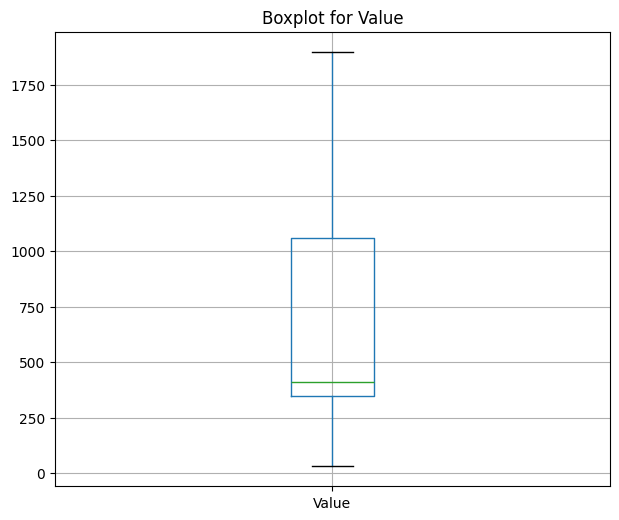

In [136]:
fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
axes = axes.flatten()

for i, column in enumerate(feature_df.columns[:rows * cols]):
    feature_df.boxplot(column=column, ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')

for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

There are no outliers.

#### 2.4.3 Check for duplicates

In [137]:
df.duplicated().sum()

np.int64(0)

There are no duplicate rows.

### 2.2 Exploratory data analysis

#### 2.2.1 Check distributions of numeric variables

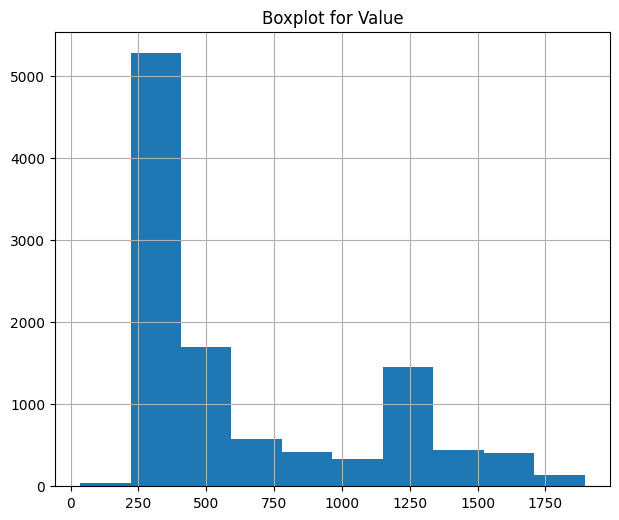

In [138]:
fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
axes = axes.flatten()

for i, column in enumerate(feature_df.columns[:rows * cols]):
    feature_df.hist(column=column, ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')

for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The data is bimodal and skewed to the right.

#### 2.2.2 Check density of numeric variables

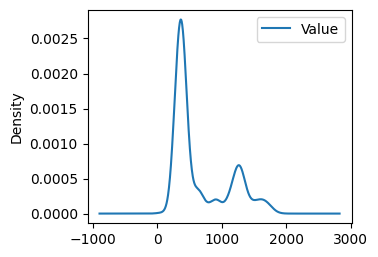

In [139]:
feature_df.plot(kind='density', subplots=True, layout=(4,4), figsize=(12,10), sharex=False)

plt.tight_layout()
plt.show()

#### 2.4.5 Check corrleations of numeric variables

There is only one feature in the dataset so there are no correlated features.

## 3.0 Data preprocessing

### 3.1 Data cleansing

#### 3.1.1 No missing values

#### 3.1.2 No duplicate rows

#### 3.1.1 No highly correlated features

### 3.2 Feature engineering

### 3.3 Data partitioning

### 3.4 Data transformation

#### 3.4.1 Parse dates as datetime

In [140]:
df['Date'] = pd.to_datetime(df['Date'])

#### 3.4.2 Sort dates

In [141]:
df = df.sort_values('Date')

## 4.0 Exploratory data analysis (EDA)

### 4.1 Determine number of clusters for k-means

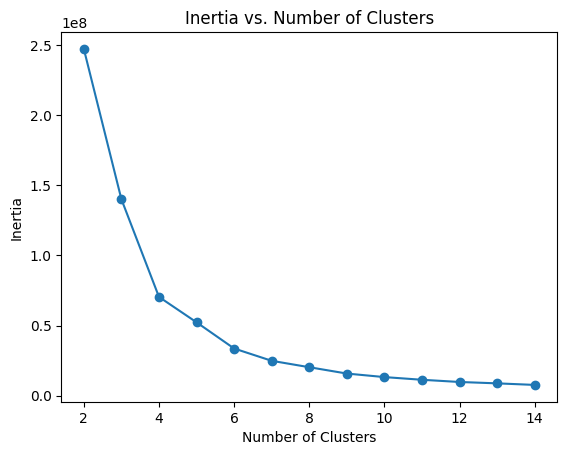

In [142]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(feature_df)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.title("Inertia vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.plot(clusters_range,inertias, marker='o')
plt.show()

Based on the elbow method, four clusters are selected for k-means.

### 4.2 Determine optimum epsilon and minimum saples for DBSCAN

In [143]:
x = feature_df.to_numpy()

In [144]:
# dbscan_cluster_model = DBSCAN(eps=0.2, min_samples=15).fit(x)
# dbscan_cluster_model

In [145]:
epsilons  = np.linspace(0.01, 1, num = 15)
epsilons

array([0.01      , 0.08071429, 0.15142857, 0.22214286, 0.29285714,
       0.36357143, 0.43428571, 0.505     , 0.57571429, 0.64642857,
       0.71714286, 0.78785714, 0.85857143, 0.92928571, 1.        ])

In [146]:
min_samples = np.arange(2, 20, step = 3)
min_samples

array([ 2,  5,  8, 11, 14, 17])

In [147]:
combinations = list (itertools.product(epsilons, min_samples))
N = len(combinations)
N

90

In [148]:
def get_scores_and_labels(combinations, x):
  scores = []
  all_labels_list = []

  for i, (eps, num_samples) in enumerate(combinations):
    dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(x)
    labels = dbscan_cluster_model.labels_
    labels_set = set(labels)
    num_clusters = len(labels_set)
    if -1 in labels_set:
      num_clusters -= 1

    if (num_clusters < 2) or (num_clusters > 100):
      scores.append(-10)
      all_labels_list.append('bad')
      c = (eps, num_samples)
      print(f"Combination {c} on iteration {i+1} of {N} has {num_clusters} clusters. Moving on")
      continue

    scores.append(ss(x, labels))
    all_labels_list.append(labels)
    print(f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, NumClusters: {num_clusters}")

  best_index = np.argmax(scores)
  best_parameters = combinations[best_index]
  best_score = scores[best_index]
  best_labels = all_labels_list[best_index]

  return {'best_epsilon': best_parameters[0], 'best_min_samples': best_parameters[1], 'best_score': best_score, 'best_labels': best_labels}

best_dict = get_scores_and_labels(combinations, x)

Combination (np.float64(0.01), np.int64(2)) on iteration 1 of 90 has 2345 clusters. Moving on
Combination (np.float64(0.01), np.int64(5)) on iteration 2 of 90 has 336 clusters. Moving on
Index: 2, Score: -0.49164145665463405, Labels: [-1 -1 -1 ... -1 -1 -1], NumClusters: 56
Index: 3, Score: -0.5152286893928911, Labels: [-1 -1 -1 ... -1 -1 -1], NumClusters: 13
Index: 4, Score: -0.514613984362474, Labels: [-1 -1 -1 ... -1 -1 -1], NumClusters: 7
Combination (np.float64(0.01), np.int64(17)) on iteration 6 of 90 has 1 clusters. Moving on
Combination (np.float64(0.08071428571428571), np.int64(2)) on iteration 7 of 90 has 1717 clusters. Moving on
Combination (np.float64(0.08071428571428571), np.int64(5)) on iteration 8 of 90 has 486 clusters. Moving on
Combination (np.float64(0.08071428571428571), np.int64(8)) on iteration 9 of 90 has 225 clusters. Moving on
Index: 9, Score: -0.35441566271322955, Labels: [-1 -1 -1 ... -1 -1 -1], NumClusters: 87
Index: 10, Score: -0.45595401002458097, Labels: 

In [149]:
best_dict

{'best_epsilon': np.float64(0.29285714285714287),
 'best_min_samples': np.int64(17),
 'best_score': np.float64(0.11613600207879018),
 'best_labels': array([-1, -1, -1, ..., -1, -1, -1])}

In [150]:
df['cluster'] = best_dict['best_labels']

In [151]:
df['cluster'].value_counts()

,count
cluster,
-1,5624
21,1432
18,372
19,232
22,212
...,...
48,17
54,17
69,17


## 5.0 Modeling

### 5.1 K-means and DBSCAN models of gold prices

#### 5.1.1 Functions for gold price analysis

In [152]:
data_gold = feature_df.to_numpy()

In [153]:
def label_generation(data_gold, var_eps, var_samples, var_clusters):
  kmeans_labels = KMeans(n_clusters=var_clusters, random_state=42).fit_predict(data_gold)
  dbscan_labels = DBSCAN(eps=var_eps, min_samples=var_samples).fit_predict(data_gold)
  return kmeans_labels, dbscan_labels

In [154]:
def cluster_plotting(data, kmeans_labels, dbscan_labels, title):
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(data, np.zeros_like(data), c=kmeans_labels)
    plt.title('K-Means Clustering')
    plt.subplot(1, 2, 2)
    plt.scatter(data, np.zeros_like(data), c=dbscan_labels)
    plt.title('DBSCAN Clustering')
    plt.suptitle(title)
    plt.show()

#### 5.1.2 Parameter settings

In [155]:
var_eps = 0.292857
var_samples = 17
var_clusters = 4

In [156]:
kmeans_labels, dbscan_labels = label_generation(data_gold, var_eps, var_samples, var_clusters)

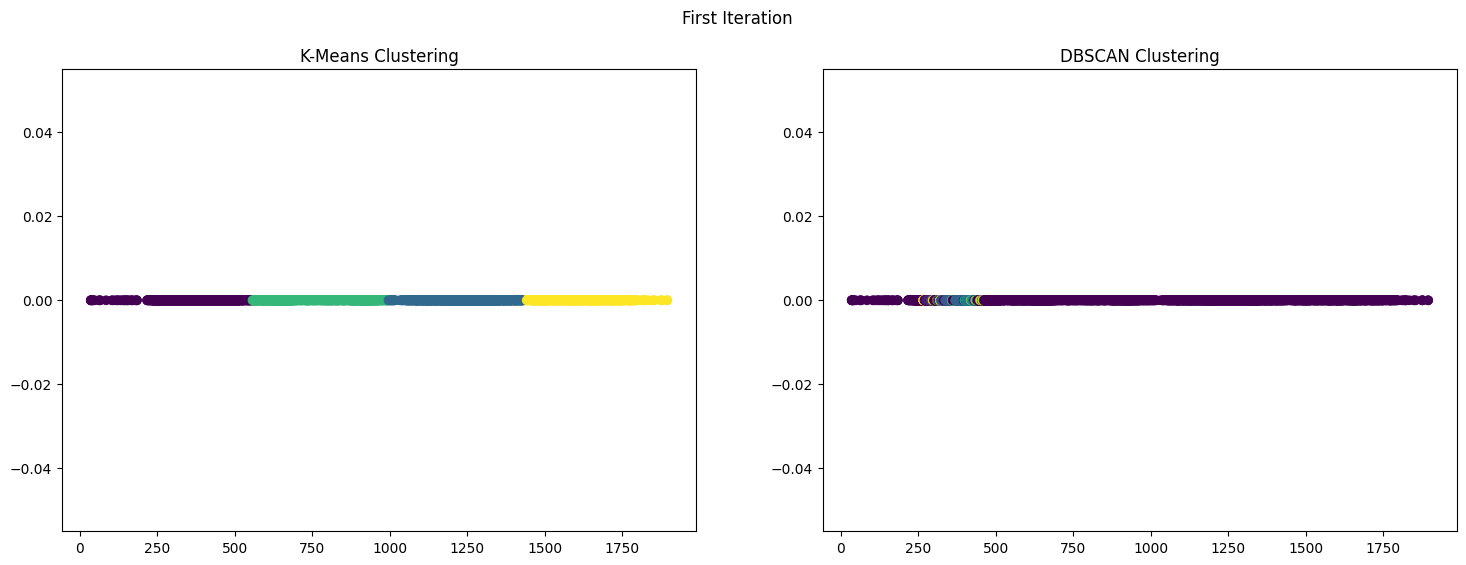

In [157]:
cluster_plotting(data_gold, kmeans_labels, dbscan_labels, 'First Iteration')

In [158]:
df['db_cluster'] = dbscan_labels
df

,Date,Value,cluster,db_cluster
0,1970-01-01,35.20,-1,-1
1,1970-04-01,35.10,-1,-1
2,1970-07-01,35.40,-1,-1
3,1970-10-01,36.20,-1,-1
4,1971-01-01,37.40,-1,-1
...,...,...,...,...
10782,2020-03-09,1672.50,-1,-1
10783,2020-03-10,1655.70,-1,-1
10784,2020-03-11,1653.75,-1,-1
10785,2020-03-12,1570.70,-1,-1


In [159]:
df['km_cluster'] = kmeans_labels
df

,Date,Value,cluster,db_cluster,km_cluster
0,1970-01-01,35.20,-1,-1,0
1,1970-04-01,35.10,-1,-1,0
2,1970-07-01,35.40,-1,-1,0
3,1970-10-01,36.20,-1,-1,0
4,1971-01-01,37.40,-1,-1,0
...,...,...,...,...,...
10782,2020-03-09,1672.50,-1,-1,3
10783,2020-03-10,1655.70,-1,-1,3
10784,2020-03-11,1653.75,-1,-1,3
10785,2020-03-12,1570.70,-1,-1,3


#### 5.1.5 K-means cluster counts

In [160]:
df['km_cluster'].value_counts()

,count
km_cluster,
0,6884
1,2031
2,1159
3,713


#### 5.1.6 DBSCAN cluster counts

In [161]:
df['db_cluster'].value_counts()

,count
db_cluster,
-1,5624
21,1432
18,372
19,232
22,212
...,...
48,17
54,17
69,17


#### 5.1.7 K-means timeline

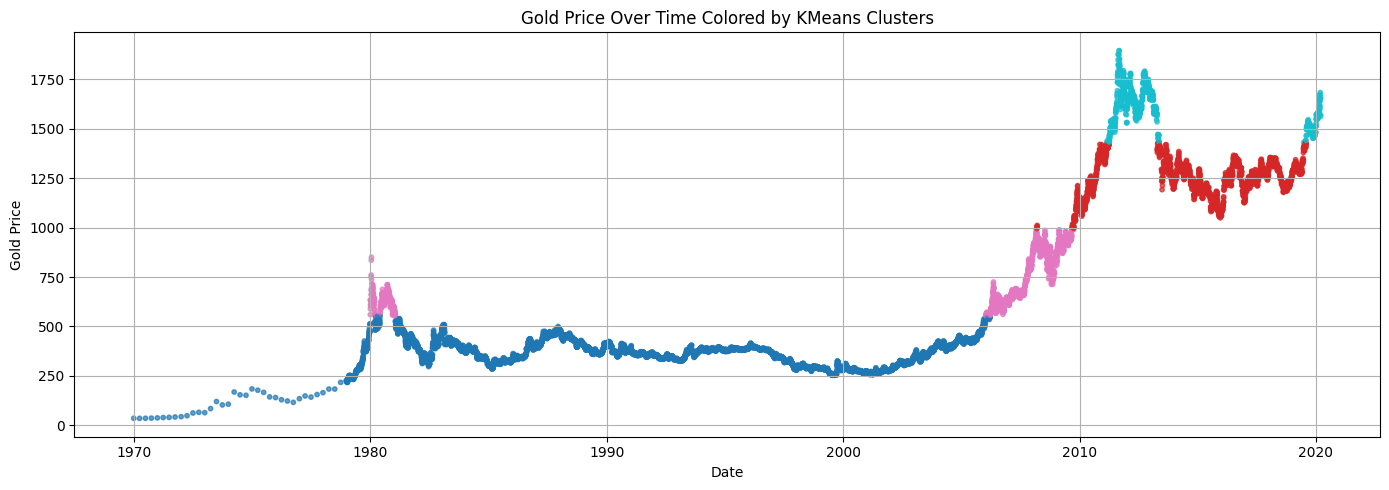

In [162]:
plt.figure(figsize=(14, 5))
plt.scatter(df['Date'], df['Value'], c=df['km_cluster'], cmap='tab10', s=10, alpha=0.7)
plt.title('Gold Price Over Time Colored by KMeans Clusters')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.grid(True)
plt.tight_layout()
plt.show()

In [163]:
fig_km = px.scatter(
    df, x='Date', y='Value', color='km_cluster',
    title='Gold Price over Time Colored by KMeans Clusters',
    labels={'Value': 'Gold Price', 'Date': 'Date'},
    opacity=0.6
)
fig_km.show()

#### 5.1.8 DBSCAN timeline

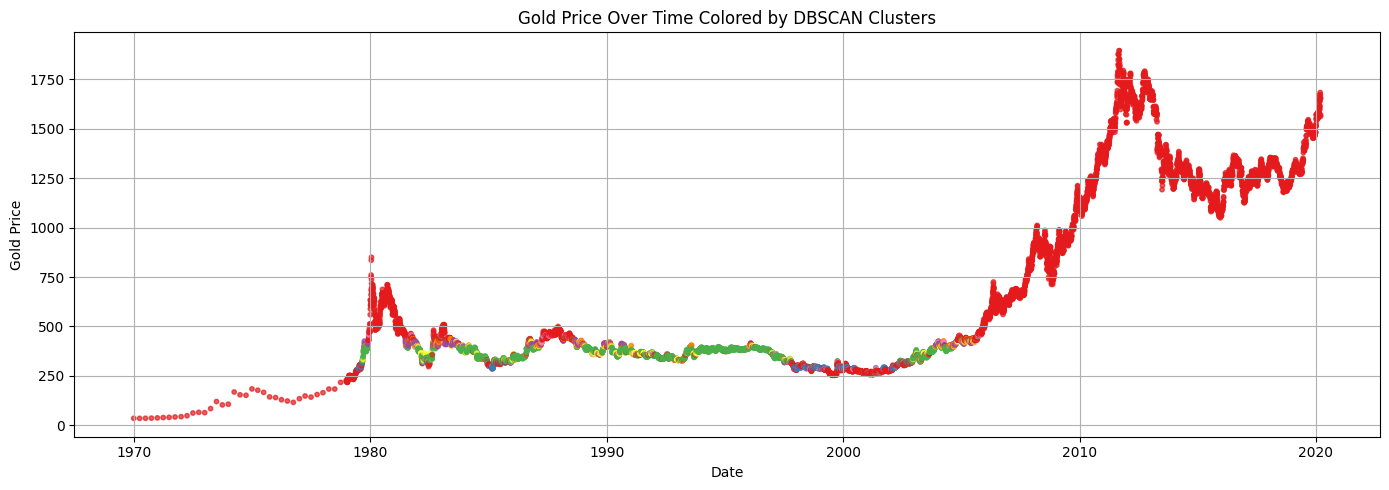

In [164]:
plt.figure(figsize=(14, 5))
plt.scatter(df['Date'], df['Value'], c=df['db_cluster'], cmap='Set1', s=10, alpha=0.7)
plt.title('Gold Price Over Time Colored by DBSCAN Clusters')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.grid(True)
plt.tight_layout()
plt.show()

In [165]:
fig_db = px.scatter(
    df, x='Date', y='Value', color='db_cluster',
    title='Gold Price over Time Colored by DBSCAN Clusters',
    labels={'Value': 'Gold Price', 'Date': 'Date'},
    opacity=0.6
)
fig_db.show()

### 5.2 Gold price analysis - subsequent parameter setttings

## 6.0 Evaluation

### 6.1 K-means silhouette score

In [166]:
ss(data_gold, df['km_cluster'])

np.float64(0.7403402326107443)

### 6.2 DBSCAN silhouette score

In [167]:
ss(data_gold, df['db_cluster'])

np.float64(0.11613600207879018)

## 7.0 Deployment

Paper: ComfortJDDS8536-1: K-means and DBSCAN Analysis of Gold Prices and California Housing